# Lab 1: Nearest Neighbor Regression and Overfitting

This is based on the notebook file [01 in Aurélien Geron's github page](https://github.com/ageron/handson-ml)

In [13]:
# Import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut
from sklearn import linear_model, neighbors
%matplotlib inline
plt.style.use('ggplot')

# Where to save the figures
PROJECT_ROOT_DIR = ".."
datapath = PROJECT_ROOT_DIR + "/data/lifesat/"

# Load and prepare data

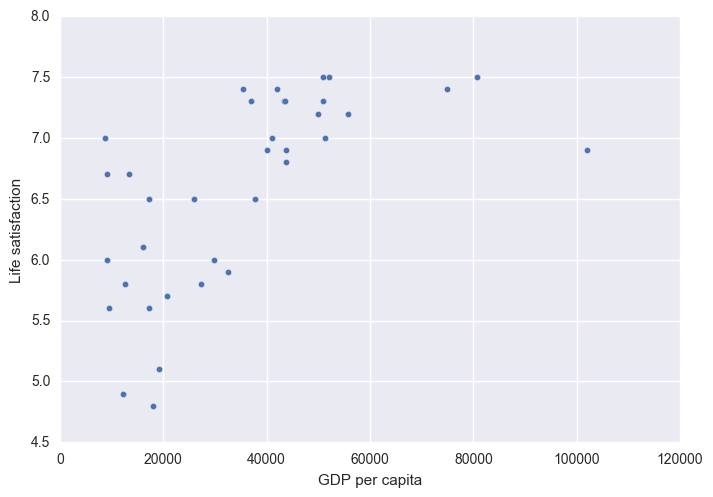

In [2]:
# Download CSV from http://stats.oecd.org/index.aspx?DataSetCode=BLI
oecd_bli = pd.read_csv(datapath+"oecd_bli_2015.csv", thousands=',')
oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")

oecd_bli.columns

oecd_bli["Life satisfaction"].head()

# Load and prepare GDP per capita data

# Download data from http://goo.gl/j1MSKe (=> imf.org)
gdp_per_capita = pd.read_csv(datapath+"gdp_per_capita.csv", thousands=',', delimiter='\t',
                             encoding='latin1', na_values="n/a")
gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
gdp_per_capita.set_index("Country", inplace=True)

full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita, left_index=True, right_index=True)
full_country_stats.sort_values(by="GDP per capita", inplace="True")

_ = full_country_stats.plot("GDP per capita",'Life satisfaction',kind='scatter')

Here's the full dataset, and there are other columns.  I will subselect a few of them by hand.

In [7]:
xvars = ['Self-reported health','Water quality','Quality of support network','GDP per capita']

In [76]:
X = np.array(full_country_stats[xvars])
y = np.array(full_country_stats['Life satisfaction'])

I will define the following functions to expedite the LOO risk and the Empirical risk.

In [79]:
def loo_risk(X,y,regmod):
    """
    Construct the leave-one-out square error risk for a regression model
    
    Input: design matrix, X, response vector, y, a regression model, regmod
    Output: scalar LOO risk
    """
    loo = LeaveOneOut()
    loo_losses = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        regmod.fit(X_train,y_train)
        y_hat = regmod.predict(X_test)
        loss = np.sum((y_hat - y_test)**2)
        loo_losses.append(loss)
    return np.mean(loo_losses)

def emp_risk(X,y,regmod):
    """
    Return the empirical risk for square error loss
    
    Input: design matrix, X, response vector, y, a regression model, regmod
    Output: scalar empirical risk
    """
    regmod.fit(X,y)
    y_hat = regmod.predict(X)
    return np.mean((y_hat - y)**2)

In [80]:
lin1 = linear_model.LinearRegression(fit_intercept=False)
print('LOO Risk: '+ str(loo_risk(X,y,lin1)))
print('Emp Risk: ' + str(emp_risk(X,y,lin1)))

LOO Risk: 0.348022001422
Emp Risk: 0.2703035744


As you can see, the empirical risk is much less than the leave-one-out risk!  This can happen in more dimensions.

## Nearest neighbor regression

Use the method described here: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

I have already imported the necessary module, so you just need to use the regression object (like we used LinearRegression)

In [20]:
# knn = neighbors.KNeighborsRegressor(n_neighbors=5)

**Exercise 1** For each k from 1 to 30 compute the nearest neighbors empirical risk and LOO risk. Plot these as a function of k and reflect on the bias-variance tradeoff here. (Hint: use the previously defined functions)

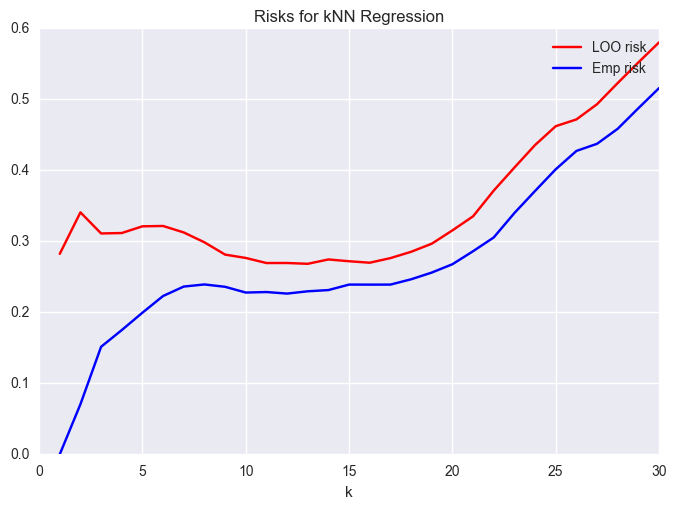

In [77]:
LOOs = []
MSEs = []
K=30
Ks = range(1,K+1)
for k in Ks:
    knn = neighbors.KNeighborsRegressor(n_neighbors=k)
    LOOs.append(loo_risk(X,y,knn))
    MSEs.append(emp_risk(X,y,knn))

plt.plot(Ks,LOOs,'r',label="LOO risk")
plt.title("Risks for kNN Regression")
plt.plot(Ks,MSEs,'b',label="Emp risk")
plt.legend()
_ = plt.xlabel('k')

I decided to see what the performance is for k from 1 to 30.  We see that the bias does not dominate until k exceeds 17, the performance is somewhat better for k around 12. This demonstrates that you can't trust the Empirical risk, since it includes the training sample.  We can compare this LOO risk to that of linear regression (0.348) and see that it outperforms linear regression.

**Exercise 2** Do the same but for the reduced predictor variables below...

In [66]:
X1 = np.array(full_country_stats[['Self-reported health']])

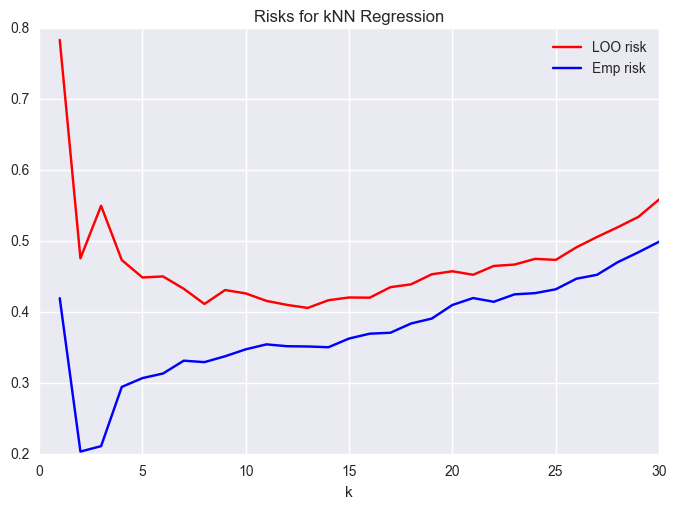

In [78]:
LOOs = []
MSEs = []
K=30
Ks = range(1,K+1)
for k in Ks:
    knn = neighbors.KNeighborsRegressor(n_neighbors=k)
    LOOs.append(loo_risk(X1,y,knn))
    MSEs.append(emp_risk(X1,y,knn))

plt.plot(Ks,LOOs,'r',label="LOO risk")
plt.title("Risks for kNN Regression")
plt.plot(Ks,MSEs,'b',label="Emp risk")
plt.legend()
_ = plt.xlabel('k')

For this one dimensional nearest neighbor method, we have a more significant cost of overfitting (k small) when the variance dominates.  